## Setting up the packages and loading the models






In [1]:
!pip install transformers

In [2]:
from google.colab import drive
import pickle
from transformers import BertTokenizer,BertModel,AutoTokenizer
import torch 

drive.mount('/content/drive', force_remount=True)
with open('drive/My Drive/ODQA/dict_idq_q_pp_15ktest.pickle',"rb") as test_file:
    test_dictionary = pickle.load(test_file)

Mounted at /content/drive


In [3]:
import os
models = os.listdir('drive/My Drive/ODQA/Models')

In [4]:
sorted(models)[:11]

['01RetrvBERT_full_8b_norm',
 '02RetrvBERT_lst2_8b_norm',
 '03RetrvBERT_full_8b',
 '04RetrvBERT_lst3_8b',
 '05RetrvBERT_lst2_8b',
 '06RetrvBERT_lst1_8b',
 '07RetrvBERT_full_notnorm_16b',
 '08RetrvBERT_lst2_16b',
 '09_RetrvBERT_lst3_8b_concat',
 '10_RetrvBERT_lst2_concat_8b',
 'BERT_2lst_10000s_50b']

In [5]:
models = ['01RetrvBERT_full_8b_norm',
 '02RetrvBERT_lst2_8b_norm',
 '03RetrvBERT_full_8b',
 '04RetrvBERT_lst3_8b',
 '05RetrvBERT_lst2_8b',
 '06RetrvBERT_lst1_8b',
 '07RetrvBERT_full_notnorm_16b',
 '08RetrvBERT_lst2_16b',
 '09_RetrvBERT_lst3_8b_concat',
 '10_RetrvBERT_lst2_concat_8b']

## Defining functions to compute similarity matrix and accuracy

In [16]:
@torch.no_grad()
def get_test_matrix(model, question, passage):
  len_ = len(question)
  embedded_qs = torch.empty(size=(len_,768))
  embedded_ps = torch.empty(size=(len_,768))
  for i in range(len_):
    embedded_qs[i] = get_embeddings(model, 
                             input_ids=question[i]['input_ids'],
                             token_type_ids=question[i]['token_type_ids'],
                             attention_mask=question[i]['attention_mask']
                             )
    embedded_ps[i] = get_embeddings(model, 
                            input_ids=passage[i]['input_ids'],
                            token_type_ids=passage[i]['token_type_ids'],
                            attention_mask=passage[i]['attention_mask']
                            )
  print("calculating the similarity matrix")
  similarity_matrix = torch.matmul(embedded_qs, torch.transpose(embedded_ps, 0, 1)) 
  
  return similarity_matrix

def get_embeddings(model, input_ids, token_type_ids, attention_mask):
  outputs = model(input_ids, 
                  token_type_ids=token_type_ids, 
                  attention_mask=attention_mask,     
                  )
  return outputs[0][:, 0, :]

def acc_from_matrix(sim_mat,n):
  counter=0
  acc=0
  for line in sim_mat:
    ind = np.argpartition(line, -n)[-n:]
    if counter in ind:
      acc+=1
    counter+=1
  return acc/counter

In [17]:
import matplotlib.pyplot as plt  
%matplotlib inline 

def showTensor(aTensor):
    plt.figure()
    plt.imshow(aTensor.numpy())
    plt.colorbar()
    plt.show()

In [13]:
import random
random.seed(42)

#init tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_token(doc, verbose=False):
  if verbose:
    print("input text: ", doc)
  return tokenizer.encode_plus(
                        doc,                     # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = 200,               # Pad & truncate all sentences.
                        pad_to_max_length=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )
def extract_sample(dictionary, sample_size):
  idxs = list(dictionary.keys()); random.shuffle(idxs);
  question = []
  q_raw = []
  passage = []
  p_raw = []
  for idx in idxs[:sample_size]:
    q = get_token(dictionary[idx]['question'])
    p = get_token(dictionary[idx]['pos_passage'])
    question.append(q)
    passage.append(p)
    q_raw.append(dictionary[idx]['question'])
    p_raw.append(dictionary[idx]['pos_passage'])
  
  return question, passage, q_raw, p_raw


In [14]:
qs_test, ps_test, q_raw, p_raw = extract_sample(test_dictionary, sample_size=1000)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [18]:
import numpy as np
k = np.arange(1, 101)
acc = {}
sim = {}

for model in sorted(models):
  print("doing accuracy for model: ", model)
  loaded_model = BertModel.from_pretrained('drive/My Drive/ODQA/Models/'+model)
  sim_matrix = get_test_matrix(loaded_model, qs_test, ps_test)
  sim[model] = sim_matrix

  for n in k:
    if model in acc.keys():
      acc[model].append(acc_from_matrix(sim_matrix,n))
    else:
      acc[model] = [acc_from_matrix(sim_matrix,n)]

doing accuracy for model:  01RetrvBERT_full_8b_norm
calculating the similarity matrix
doing accuracy for model:  02RetrvBERT_lst2_8b_norm
calculating the similarity matrix
doing accuracy for model:  03RetrvBERT_full_8b
calculating the similarity matrix
doing accuracy for model:  04RetrvBERT_lst3_8b
calculating the similarity matrix
doing accuracy for model:  05RetrvBERT_lst2_8b
calculating the similarity matrix
doing accuracy for model:  06RetrvBERT_lst1_8b
calculating the similarity matrix
doing accuracy for model:  07RetrvBERT_full_notnorm_16b
calculating the similarity matrix
doing accuracy for model:  08RetrvBERT_lst2_16b
calculating the similarity matrix
doing accuracy for model:  09_RetrvBERT_lst3_8b_concat
calculating the similarity matrix
doing accuracy for model:  10_RetrvBERT_lst2_concat_8b
calculating the similarity matrix
doing accuracy for model:  BERT_2lst_10000s_50b
calculating the similarity matrix


In [25]:
with open('drive/My Drive/ODQA/accuracy_dictionary.pickle', 'wb') as f:
    pickle.dump(acc, f)

In [26]:
with open('drive/My Drive/ODQA/similarity_matrix_dictionary.pickle', 'wb') as f:
    pickle.dump(sim, f)

In [5]:
with open('drive/My Drive/ODQA/accuracy_dictionary.pickle',"rb") as dict_file:
    acc_dictionary = pickle.load(dict_file)

In [8]:
with open('drive/My Drive/ODQA/similarity_matrix_dictionary.pickle',"rb") as dict_file:
    sim_dictionary = pickle.load(dict_file)

In [9]:
sim_dictionary.keys()

dict_keys(['01RetrvBERT_full_8b_norm', '02RetrvBERT_lst2_8b_norm', '03RetrvBERT_full_8b', '04RetrvBERT_lst3_8b', '05RetrvBERT_lst2_8b', '06RetrvBERT_lst1_8b', '07RetrvBERT_full_notnorm_16b', '08RetrvBERT_lst2_16b', '09_RetrvBERT_lst3_8b_concat', '10_RetrvBERT_lst2_concat_8b'])

## TF-IDF

In [21]:
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

class TFidf:
    def tfidf_vectors(self, corpus):    
        vectorizer = TfidfVectorizer()
        vectors = vectorizer.fit_transform(corpus)
        feature_names = vectorizer.get_feature_names()
        dense = vectors.todense()
        denselist = dense.tolist()
    
        return pd.DataFrame(denselist, columns=feature_names)

    def tfidf_embedding(self, corpus):
        embeddings = []  

        df = self.tfidf_vectors(corpus)

        for _, row in df.iterrows():
            embeddings.append(np.array(row))

        sim_to_quest = []
        for _, emb_i in enumerate(embeddings[1:]):
            sim_to_quest.append(np.dot(emb_i, embeddings[0]))
        
        return sim_to_quest

In [ ]:
sim_matrix = []
tf=TFidf()
for i in range(len(q_raw)):
  corpus =  list(itertools.chain(*[[q_raw[i]],p_raw]))
  sim_matrix.append(tf.tfidf_embedding(corpus))

sim['tf-idf'] = sim_matrix

for n in k:
    if 'tf-idf' in acc.keys():
      acc['tf-idf'].append(acc_from_matrix(sim_matrix,n))
    else:
      acc['tf-idf'] = [acc_from_matrix(sim_matrix,n)]

## Random baseline

In [24]:
rand_matrix = np.random.rand(len(qs_test),len(qs_test))

for n in k:
    if 'random_baseline' in acc.keys():
      acc['random_baseline'].append(acc_from_matrix(rand_matrix,n))
    else:
      acc['random_baseline'] = [acc_from_matrix(rand_matrix,n)]

## Plot

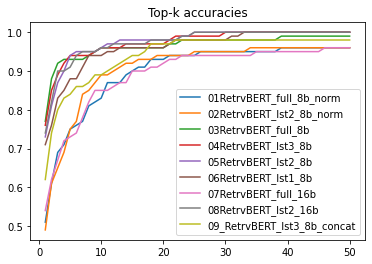

In [18]:
for key in acc.keys():
  plt.plot(k, acc[key], label=key)

plt.title("Top-k accuracies")
plt.legend()
plt.show()

In [23]:
avg_mean = []
for key in acc.keys():
  avg_mean.append([key, np.mean(acc[key])])

In [25]:
avg_mean.sort(key=lambda x: x[1])

In [26]:
avg_mean

[['07RetrvBERT_full_16b', 0.892],
 ['01RetrvBERT_full_8b_norm', 0.8968],
 ['02RetrvBERT_lst2_8b_norm', 0.905],
 ['09_RetrvBERT_lst3_8b_concat', 0.9397999999999999],
 ['06RetrvBERT_lst1_8b', 0.9598],
 ['03RetrvBERT_full_8b', 0.9648],
 ['04RetrvBERT_lst3_8b', 0.9732000000000001],
 ['08RetrvBERT_lst2_16b', 0.9736],
 ['05RetrvBERT_lst2_8b', 0.9745999999999999]]

In [ ]:
len(sim_matrix)

In [ ]:
accuracies =[ [ None for y in range(1,100) ] 
             for x in range(len(sim_matrix)) ] 
accuracies[0][1]


In [ ]:
for i in range(99):
  for j,_ in enumerate(models):
    accuracies[j][i]=acc_from_matrix(sim_matrix[j],i+1)

In [ ]:
accuracies[0]